In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("isaienkov/deforestation-in-ukraine")

print("Path to dataset files:", path)

/home/epele/micromamba/envs/license/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 32.7G/32.7G [16:47<00:00, 34.8MB/s]  

Extracting files...


Path to dataset files: /home/epele/.cache/kagglehub/datasets/isaienkov/deforestation-in-ukraine/versions/1


In [4]:
path = "/home/epele/.cache/kagglehub/datasets/isaienkov/deforestation-in-ukraine/versions/1"
df = gpd.read_file(path + "/deforestation_labels.geojson")
print("Number of polygons:", len(df))
df.head()

Number of polygons: 5696


,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.7913 50.17406, 35.79277 50.17354,..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.7781 50.10318,..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."


In [6]:
RASTER_PATH = path + '/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
    raster_image = src.read()
    raster_meta = src.meta

In [7]:
raster_image.shape
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 5600040.0)}

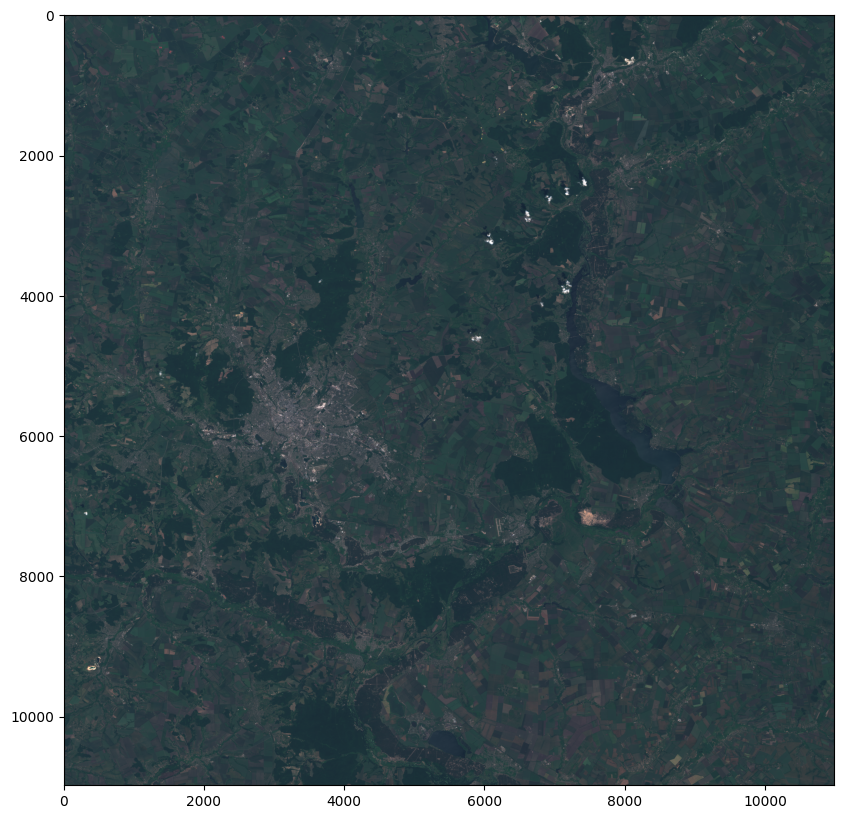

In [8]:
raster_img = reshape_as_image(raster_image)
plt.figure(figsize=(10, 10))
plt.imshow(raster_img)

In [ ]:
# assigning crs
# use 4236 for tiles from this dataset

df

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((699218.537 5562133.702, 699325.839 5..."
1,2016-04-09,36UXA,"POLYGON ((698459.426 5554162.662, 698569.358 5..."
2,2016-04-09,36UXA,"POLYGON ((699524.788 5544189.095, 699516.903 5..."
3,2016-04-09,36UXA,"POLYGON ((699114.519 5543371.364, 699244.558 5..."
4,2016-04-09,36UXA,"POLYGON ((700426.849 5542320.373, 700517.265 5..."
...,...,...,...
5691,2019-09-09,36UYA,"POLYGON ((740891.051 5563826.491, 740899.346 5..."
5692,2019-09-09,36UYA,"POLYGON ((741145.387 5563811.991, 741147.24 55..."
5693,2019-09-09,36UYA,"POLYGON ((707816.789 5568031.074, 707813.722 5..."
5694,2019-10-26,36UYA,"POLYGON ((776636.52 5575832.368, 776710.566 55..."


/home/epele/micromamba/envs/license/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


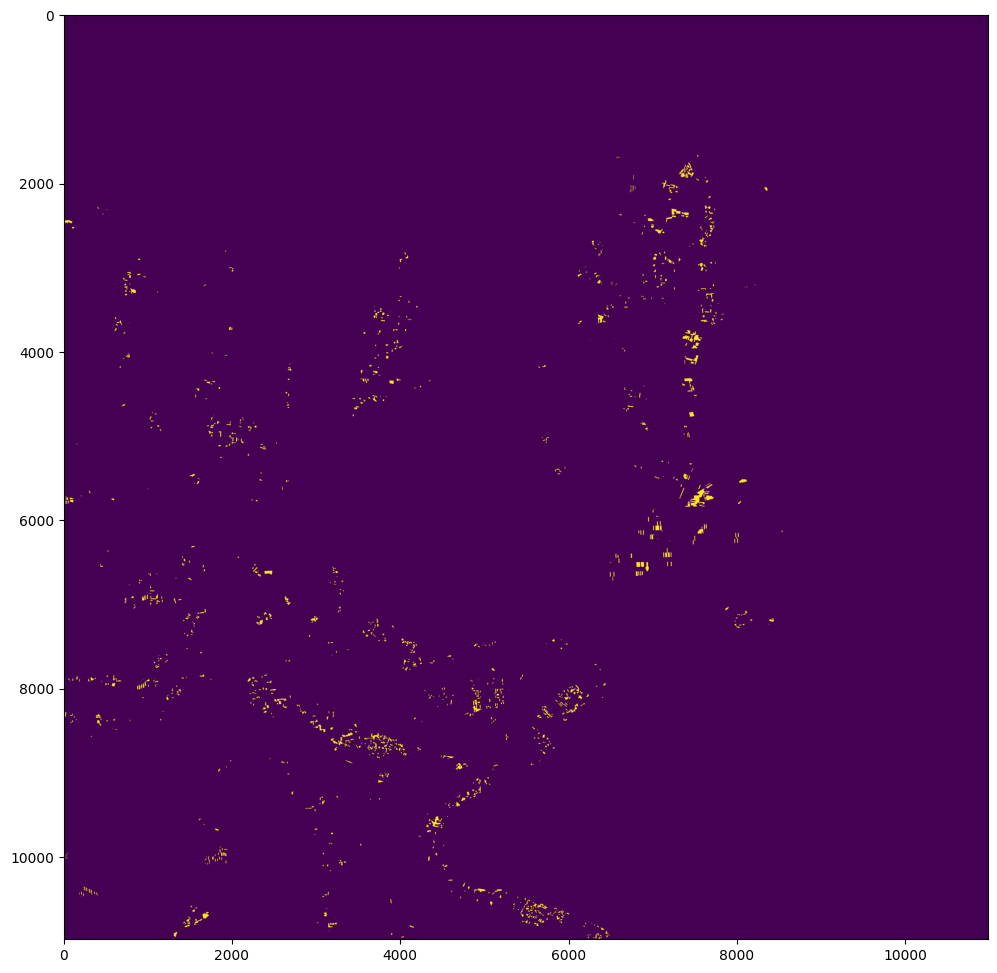

In [13]:
from rasterio.features import rasterize

RASTER_PATH = path + '/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
    raster_image = src.read()
    raster_meta = src.meta

    raster_img = reshape_as_image(raster_image)

    df.crs = {'init':'epsg:4236'}

    #transforming polygons to the raster crs
    df = df.to_crs(raster_meta['crs'])
    # `src` is your opened Sentinel-2 raster

    shapes = [(geom, 1) for geom in df.geometry]
    mask = rasterize(
        shapes,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype='uint8'
    )
    # mask now is a (H,W) array of 0/1
    plt.figure(figsize=(12,12))
    plt.imshow(mask)

In [34]:
import rasterio
from rasterio.features import rasterize

# Open one example Sentinel-2 tile to get metadata
with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
    transform = src.transform
    height, width = src.height, src.width

# Prepare shapes as (geometry, value) pairs
shapes = [(geom, 1) for geom in df.geometry]

# Rasterize to binary mask
mask = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

In [35]:
import numpy as np

with rasterio.open(RASTER_PATH) as src:
    # Example for 3 bands; adjust indexes for your dataset
    red   = src.read(1)
    green = src.read(2)
    blue  = src.read(3)

# Stack into (H, W, 3)
image = np.stack([red, green, blue], axis=-1).astype('float32') / 10000.0

In [39]:
df.head()

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((699218.537 5562133.702, 699325.839 5..."
1,2016-04-09,36UXA,"POLYGON ((698459.426 5554162.662, 698569.358 5..."
2,2016-04-09,36UXA,"POLYGON ((699524.788 5544189.095, 699516.903 5..."
3,2016-04-09,36UXA,"POLYGON ((699114.519 5543371.364, 699244.558 5..."
4,2016-04-09,36UXA,"POLYGON ((700426.849 5542320.373, 700517.265 5..."


# Preprocess the data

In [12]:
folders_path = '/home/epele/.cache/kagglehub/datasets/isaienkov/deforestation-in-ukraine/versions/1/'

df = gpd.read_file(path + "/deforestation_labels.geojson")
print("Number of polygons:", len(df))
df.head()

Number of polygons: 5696


,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.7913 50.17406, 35.79277 50.17354,..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.7781 50.10318,..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."


# MODEL

In [53]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, Activation,
    MaxPooling2D, UpSampling2D,
    add, multiply, concatenate
)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, UpSampling2D,
    add, multiply, Lambda
)

'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
    shape_x = K.int_shape(x)
    # 1x1 conv + pool on x
    theta_x = Conv2D(inter_shape, 1, padding='same')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)

    # 1x1 conv on gating signal
    phi_g = Conv2D(inter_shape, 1, padding='same')(gating)

    act_xg = Activation('relu')(add([phi_g, theta_x]))
    psi    = Conv2D(1, 1, padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)

    # Upsample back to x’s spatial dims
    upsample_psi = UpSampling2D(
        interpolation='bilinear',
        size=(
            shape_x[1] // K.int_shape(sigmoid_xg)[1],
            shape_x[2] // K.int_shape(sigmoid_xg)[2]
        )
    )(sigmoid_xg)

    # Wrap broadcast inside a Keras layer
    upsample_psi = Lambda(
        lambda t: tf.broadcast_to(t, shape_x)
    )(upsample_psi)

    # Elementwise multiplication (broadcasting mask over channels)
    y = multiply([upsample_psi, x])
    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [54]:
model = UNetAM()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (1, 512, 512, 16) │        448 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_119      │ (1, 512, 512, 16) │          0 │ conv2d_136[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (1, 512, 512, 16) │      2,320 │ activation_119[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (1, 512, 512, 16) │          0 │ conv2d_137[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (1, 256, 256, 16) │          0 │ activation_120[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (1, 256, 256, 32) │      4,640 │ max_pooling2d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_121      │ (1, 256, 256, 32) │          0 │ conv2d_138[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (1, 256, 256, 32) │      9,248 │ activation_121[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_122      │ (1, 256, 256, 32) │          0 │ conv2d_139[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (1, 128, 128, 32) │          0 │ activation_122[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (1, 128, 128, 64) │     18,496 │ max_pooling2d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_123      │ (1, 128, 128, 64) │          0 │ conv2d_140[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (1, 128, 128, 64) │     36,928 │ activation_123[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_124      │ (1, 128, 128, 64) │          0 │ conv2d_141[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (1, 64, 64, 64)   │          0 │ activation_124[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (1, 64, 64, 128)  │     73,856 │ max_pooling2d_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_125      │ (1, 64, 64, 128)  │          0 │ conv2d_142[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (1, 64, 64, 128)  │    147,584 │ activation_125[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,006,292 (7.65 MB)

 Trainable params: 2,006,292 (7.65 MB)

 Non-trainable params: 0 (0.00 B)